# Oversmoothing Analysis of Node Classification

### Setup

In [2]:
import os

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.utils import add_remaining_self_loops, degree
from torch_scatter import scatter
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool, GCNConv, GATConv, SimpleConv
from torch_geometric.datasets import HeterophilousGraphDataset
from torch_geometric.loader import DataLoader
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 1) Find and Download Datasets for Node Classification dataset link

***Roman Empire***

* Based on the Roman Empire article from Wikipedia
* Each node corresponds to a word in the text
* Each word is connected to another if the word follows or there is a dependency within the sentence
* The class of the node is its syntactic role found using spaCy
* Node features are fastText word embeddings

In [9]:
rome = HeterophilousGraphDataset(root='data/', name='Roman-empire')

***Amazon Ratings***

* Nodes are products
* Edges connect products frequently bought together
* Predict binned average rating
* Features are mean of text embeddings of product descriptions

In [4]:
amazon = HeterophilousGraphDataset(root='data/', name='Amazon-ratings')

***Minesweeper***

* 100x100 grid
* Each cell is connected to its eight neighbors
* Mines vs not mines
  * Binary classes
  * 20% are mines
* Node features are one-hot-encoded numbers of neighboring mines

In [5]:
minesweeper = HeterophilousGraphDataset(root='data/', name='Minesweeper')

***Tolokers***

* Toloka crowdsourcing platform
* Nodes are workers
* Edges indicate collaborators
* Node features are profile information/performance statistics
* Classes indicate whether worker was banned

In [67]:
tolo = HeterophilousGraphDataset(root='data/', name='Tolokers')

***Questions***

In [9]:
questions = HeterophilousGraphDataset(root='data/', name='Questions')

### 2) Code GNN-based models and obtain node classification performance

In [78]:
results = pd.read_csv("experiment_results.csv")

def tuple_length(config_str):
    items = config_str.strip("()").split(",")
    return len([item for item in items if item.strip()]) + 1
results["num_conv_layers"] = results.configuration.apply(tuple_length)

display(results)

,model_type,configuration,dataset,accuracy,precision,recall,f1,roc_auc,runtime,notes,num_conv_layers
0,GCN,"(512,)",Roman-empire,0.6636,0.6293,0.6636,0.6272,0.9166,17.160276,Success,2
1,GCN,"(512, 256)",Roman-empire,0.6712,0.6546,0.6712,0.6368,0.9155,22.120041,Success,3
2,GCN,"(512, 256, 128)",Roman-empire,0.6500,0.6375,0.6500,0.6179,0.9119,25.539171,Success,4
3,GAT,"(512,)",Roman-empire,0.7580,0.7504,0.7580,0.7526,0.9599,73.576344,Success,2
4,GAT,"(512, 256)",Roman-empire,0.7621,0.7568,0.7621,0.7582,0.9594,113.042035,Success,3
5,GAT,"(512, 256, 128)",Roman-empire,0.7716,0.7674,0.7716,0.7683,0.9594,126.069927,Success,4
6,GCN,"(512,)",Amazon-ratings,0.4628,0.4453,0.4628,0.4232,0.6920,24.668529,Success,2
7,GCN,"(512, 256)",Amazon-ratings,0.4787,0.4431,0.4787,0.4554,0.7122,33.965426,Success,3
8,GCN,"(512, 256, 128)",Amazon-ratings,0.4766,0.4673,0.4766,0.4553,0.7114,38.736187,Success,4
9,GAT,"(512,)",Amazon-ratings,0.5078,0.5017,0.5078,0.4998,0.7315,114.963037,Success,2


### 3) Change the Message-passing layer and obtain performance for each layer

In [79]:
def plot_results(results, data_name, metric_name, color="blue"):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3.2), sharey=True)

    df = results[results["dataset"] == data_name]

    sns.lineplot(df[df.model_type == "GCN"], x="num_conv_layers", y=metric_name, ax=axes[0], color=color)
    sns.lineplot(df[df.model_type == "GAT"], x="num_conv_layers", y=metric_name, ax=axes[1], color=color)

    axes[0].set_title("GCN")
    axes[1].set_title("GAT")

    for ax in axes:
        ax.set_xticks([2, 3, 4])
        ax.set_axisbelow(True)
        ax.grid(alpha=0.7)

    plt.suptitle(f"{data_name} ({metric_name})")

    plt.tight_layout()

    plt.show()

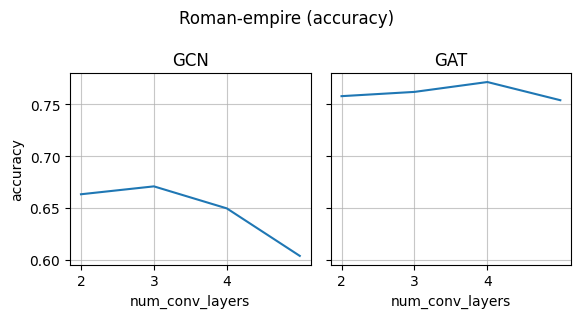

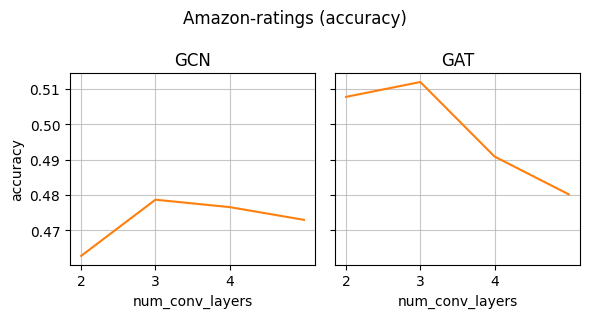

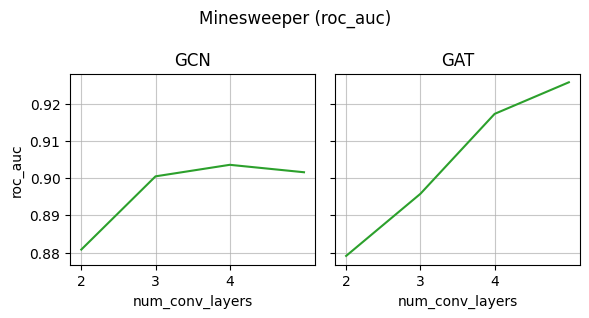

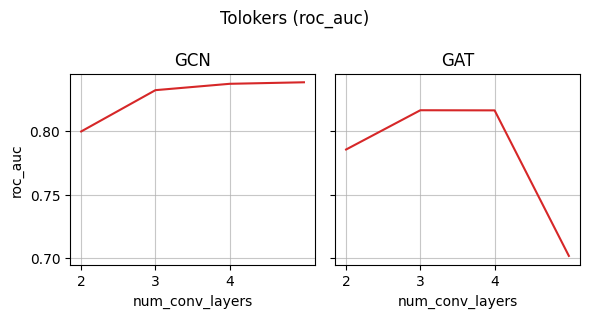

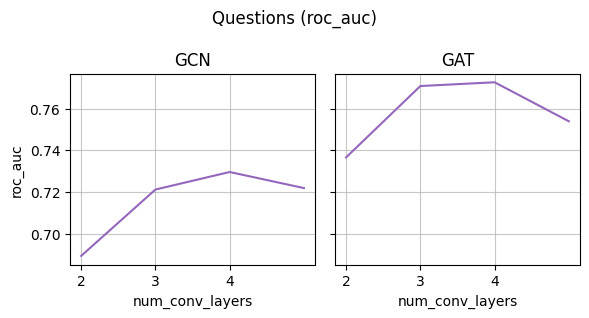

In [80]:
dataset_names = list(results.dataset.unique())
metric_list = ["accuracy", "accuracy", "roc_auc", "roc_auc", "roc_auc"]
palette = sns.color_palette("tab10", len(dataset_names))

for data_name, metric, color in zip(dataset_names, metric_list, palette):
    plot_results(results, data_name, metric, color)

### 4) Analyze the relationship between the number of message-passing layers and the node classification performance
* Visualize oversmoothing

In [ ]:
class Analyzer:
    def __init__(self):
        self.tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, max_iter=1000)

    def fit_tsne(self, data):
        self.tsne.

In [ ]:
# Load model from file
model = GAT(
    in_channels=dataset.num_node_features,
    conv_channels=conv_channels_list,
    mlp_channels=mlp_channels_list,
    out_channels=dataset.num_classes,
    heads=num_heads,
).to(device)

model.load_state_dict(torch.load(weights_path, weights_only=True))

<All keys matched successfully>

In [13]:
loader = DataLoader(dataset, batch_size=1) #shuffle=True)

batch = next(iter(loader))
with torch.no_grad():
    logits, embeddings = model(batch.x, batch.edge_index, return_emb=True)

predictions = logits.argmax(dim=1)
predictions

tensor([ 3, 10,  6,  ...,  4,  4, 12], device='cuda:0')

In [14]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, max_iter=1000)

emb_2d = []

for i, emb in enumerate(embeddings):
    emb_2d.append(tsne.fit_transform(emb.cpu().numpy()))

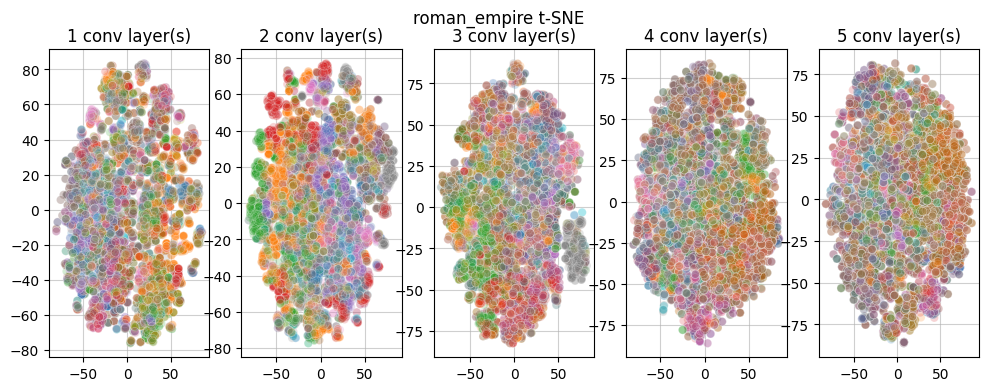

In [15]:
def plot_tsne(emb_2d, legend=True):
    n_emb = len(emb_2d)

    labels = dataset.y.cpu()

    fig, axes = plt.subplots(1, n_emb, figsize=(12, 4))

    for i, ax in enumerate(axes):

        end = 10000
        data = emb_2d[i][:end]

        x = data[:, 0]
        y = data[:, 1]

        sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels[:end], ax=ax, alpha=0.2, palette="tab10")
                        
        ax.set_title(f"{i + 1} conv layer(s)")
        if not legend:
            ax.get_legend().remove()
        ax.set_axisbelow(True)
        ax.grid(alpha=0.6)

    plt.suptitle(f"{dataset.name} t-SNE")

    plt.show()

plot_tsne(emb_2d, legend=False)